In [1]:
import os
os.chdir('../../')

In [2]:
cd = os.getcwd()
functions_path = os.path.join(cd, '02_code/functions')

In [3]:
#import required packages

import scanpy as sc
import scanpy.external as sce
import numpy as np
import pandas as pd
import anndata as ad
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix
from anndata import AnnData
import skmisc

import anndata2ri
import logging
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

# from scipy.sparse import csr_matrix
import sys
sys.path.append(functions_path)
import functions_dat_processing as dp

/tmp/ipykernel_2480541/3606276056.py:20: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [ ]:
#install required bioconductor and github packages
bioc = ro.packages.importr('BiocManager') 
remotes = ro.packages.importr('remotes')
utils = ro.packages.importr('utils')
utils.chooseCRANmirror(ind=1)

bioc.install('scran')
bioc.install('BiocParallel')
bioc.install('scry')

remotes.install_github('carmonalab/STACAS') #for integration based on MNNs
remotes.install_github('carmonalab/ProjecTILs') #for annotating Tcell subtypes
bioc.install('UCell')
utils.install_packages('scGate')#for celltype annotation

<rpy2.rinterface_lib.sexp.NULLType object at 0x7fec77dd0210> [0]

In [4]:
#import required R packages
soupx = ro.packages.importr('SoupX') 
scran = ro.packages.importr('scran') 
bcp = ro.packages.importr('BiocParallel') 
scry = ro.packages.importr('scry')
stacas = ro.packages.importr('STACAS')
scgate = ro.packages.importr('scGate')
Matrix = ro.packages.importr('Matrix')
ProjecTILs = ro.packages.importr('ProjecTILs')
seurat = ro.packages.importr('Seurat')
# %R print(packageVersion("Seurat"))


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

### 1. Import all the data

In [161]:
%R -i ada -i ada_hto
%R set.seed(1234)
%R data2 <- Read10X("~/car_t_sc/01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P9_cellranger/per_sample_outs/count/sample_filtered_feature_bc_matrix")
# %R assay(ada, 'X') <- as(as.matrix(assay(ada, 'X')), 'dgCMatrix')
# %R assay(ada_hto, 'X') <- as(as.matrix(assay(ada_hto, 'X')), 'dgCMatrix')
# #convert to seurat object
# %R seurat_obj2 <- CreateSeuratObject(counts = assay(ada, 'X'))
# #create HTO assay
# %R seurat_obj2[["HTO"]] <- CreateAssayObject(counts = assay(ada_hto, 'X')) 
# #createSeuratObject

%R seurat_obj2 <- CreateSeuratObject(counts=data2$'Gene Expression')
%R seurat_obj2[['HTO']] <- CreateAssayObject(counts=data2$'Antibody Capture')
# %R m <- seurat_obj2[['HTO']]@counts[0:5,]
# %R seurat_obj2[['HTO']] <- CreateAssayObject(counts=m)

# %R seurat_obj2 <- NormalizeData(seurat_obj2, assay= "HTO", normalization.method= "CLR")
#KeepNo-zeroHTOCounts
%R counts <- GetAssayData(seurat_obj2, assay = "HTO", layer = "counts")
%R zero_count_cells <- colnames(counts[, colSums(counts) == 0])
%R seurat_objj <- subset(seurat_obj2, cells = setdiff(colnames(seurat_obj2), zero_count_cells))

%R seurat_objj <- HTODemux(seurat_objj, assay = "HTO", kfunc="clara", positive.quantile = 0.99)
%R print(table(seurat_objj$HTO_classification.global))


 Doublet Negative  Singlet 
    3535     7472     5809 


'value'

In [5]:
path_to_folders = './01_data/raw/cellranger_multi'
path_to_count_matrices_in_folders = 'per_sample_outs/count/sample_filtered_feature_bc_matrix'
path_to_raw_count_matrices_in_folders = 'count/raw_feature_bc_matrix'

adatas = dp.read_all_pools(path_to_folders, path_to_count_matrices_in_folders)
# adatas_raw = dp.read_all_pools(path_to_folders, path_to_raw_count_matrices_in_folders)

Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P1_cellranger/per_sample_outs/count/sample_filtered_feature_bc_matrix
Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P2_cellranger/per_sample_outs/count/sample_filtered_feature_bc_matrix
Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P3_cellranger/per_sample_outs/count/sample_filtered_feature_bc_matrix
Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P4_cellranger/per_sample_outs/count/sample_filtered_feature_bc_matrix
Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P5_cellranger/per_sample_outs/count/sample_filtered_feature_bc_matrix
Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P6_cellranger/per_sample_outs/count/sample_filtered_feature_bc_matrix
Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P7_cellranger/per_sample_outs/count/sample_filtered_feature_bc_matrix
Reading from: ./01_data/raw/cellra

### 2. Demultiplex using HTODemux

In [6]:
import importlib
importlib.reload(dp)

<module 'functions_dat_processing' from '/home/s377963/car_t_sc/02_code/functions/functions_dat_processing.py'>

In [7]:
hto_and_adata_list = [dp.generate_hto_adata_object(adata, rename=True) for adata in adatas]
zipped = list(zip(*hto_and_adata_list))
adata_htos = zipped[0]
adata_nohtos = zipped[1]

In [8]:
norm =[3,4,5,6,8]

for i, (adata, adata_hto) in enumerate(zip(adata_nohtos, adata_htos)):
    #import data
    %R -i adata -i adata_hto
    #convert dgRMatrix to dgCMatrix
    %R assay(adata_hto, 'X') <- as(as.matrix(assay(adata_hto, 'X')), 'dgCMatrix')
    %R assay(adata, 'X') <- as(as.matrix(assay(adata, 'X')), 'dgCMatrix')
    #convert to seurat object
    %R adata_seurat <- CreateSeuratObject(counts = assay(adata, 'X'))
    #create HTO assay
    %R adata_seurat[["HTO"]] <- CreateAssayObject(counts = assay(adata_hto, 'X') + 1) #+1 adds a small pseudocount to avoid clusters with cells containing only 0 counts for a given HTO
    #normalize hto counts (for some pools)
    %R adata_seurat <- NormalizeData(adata_seurat, assay = "HTO", normalization.method = "CLR")
    %R adata_seurat <- HTODemux(adata_seurat, assay = "HTO", positive.quantile = 0.99, kfunc = 'kmeans')
    %R print(table(adata_seurat$HTO_classification.global))
    #export to python and append to adata object
    %R sample_class <- adata_seurat$HTO_classification
    %R sample_class_global <- adata_seurat$HTO_classification.global
    %R -o sample_class
    %R -o sample_class_global
    adata.obs['Classification'] = sample_class
    adata.obs['Classification_global'] = sample_class_global
adatas_singlets = [dp.filter_for_singlets(adata, column="Classification_global") for adata in adata_nohtos]

  |                                                  | 0 % ~calculating   |+++++++++++++++++                                 | 33% ~00s           |++++++++++++++++++++++++++++++++++                | 67% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=00s  
As of Seurat v5, we recommend using AggregateExpression to perform pseudo-bulk analysis.
This message is displayed once per session.
First group.by variable `ident` starts with a number, appending `g` to ensure valid variable names
This message is displayed once every 8 hours.

 Doublet Negative  Singlet 
     707     3212     5105 
  |                                                  | 0 % ~calculating   |+++++++++                                         | 17% ~00s           |+++++++++++++++++                                 | 33% ~00s           |+++++++++++++++++++++++++                         | 50% ~00s           |++++++++++++++++++++++++++++++++++                | 67% ~00s           |++++++++++++

In [11]:
# not_norm = [1,2,7,9]
norm =[3,4,5,6,8]

for i, (adata, adata_hto) in enumerate(zip(adata_nohtos, adata_htos)):
    #import data
    %R -i adata -i adata_hto
    #convert dgRMatrix to dgCMatrix
    %R assay(adata_hto, 'X') <- as(as.matrix(assay(adata_hto, 'X')), 'dgCMatrix')
    %R assay(adata, 'X') <- as(as.matrix(assay(adata, 'X')), 'dgCMatrix')
    #convert to seurat object
    %R adata_seurat <- CreateSeuratObject(counts = assay(adata, 'X'))
    #create HTO assay
    %R adata_seurat[["HTO"]] <- CreateAssayObject(counts = assay(adata_hto, 'X')) #+1 adds a small pseudocount to avoid clusters with cells containing only 0 counts for a given HTO
    #normalize hto counts (for some pools)
    if i+1 in norm:
        %R adata_seurat <- NormalizeData(adata_seurat, assay = "HTO", normalization.method = "CLR")
    #Demultiplex using HTODemux (note: different clustering methods for different pools)
    if i+1 == 9:
        %R adata_seurat <- HTODemux(adata_seurat, assay = "HTO", positive.quantile = 0.99, kfunc = 'clara')
    else:
        %R adata_seurat <- HTODemux(adata_seurat, assay = "HTO", positive.quantile = 0.99, kfunc = 'kmeans')
    %R print(table(adata_seurat$HTO_classification.global))
    #export to python and append to adata object
    %R sample_class <- adata_seurat$HTO_classification
    %R sample_class_global <- adata_seurat$HTO_classification.global
    %R -o sample_class
    %R -o sample_class_global
    adata.obs['Classification'] = sample_class
    adata.obs['Classification_global'] = sample_class_global
adatas_singlets = [dp.filter_for_singlets(adata, column="Classification_global") for adata in adata_nohtos]
    


 Doublet Negative  Singlet 
     119     7081     1824 

 Doublet Negative  Singlet 
      72       35     1245 
  |                                                  | 0 % ~calculating   |+++++++++                                         | 17% ~00s           |+++++++++++++++++                                 | 33% ~00s           |+++++++++++++++++++++++++                         | 50% ~00s           |++++++++++++++++++++++++++++++++++                | 67% ~00s           |++++++++++++++++++++++++++++++++++++++++++        | 83% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=00s  

 Doublet Negative  Singlet 
     145       50     1312 
  |                                                  | 0 % ~calculating   |+++++++++                                         | 17% ~00s           |+++++++++++++++++                                 | 33% ~00s           |+++++++++++++++++++++++++                         | 50% ~00s           |++++++++++++++++++++++++++++++++

### 3. perform quality control

In [12]:
# adatas_mad = dp.quality_control(adatas_singlets)
# adatas_qc = dp.quality_control(adatas_singlets)
# adatas_qc = dp.quality_control(adatas_singlets, method = 'qntl')
adatas_qc = dp.quality_control(adatas_singlets, method = 'abs')
adatas_qc_raw = dp.quality_control(adatas, method = 'abs')

computing qc for Pool 1
computing qc for Pool 2
computing qc for Pool 3
computing qc for Pool 4
computing qc for Pool 5
computing qc for Pool 6
computing qc for Pool 7
computing qc for Pool 8
computing qc for Pool 9
computing qc for Pool 1
computing qc for Pool 2
computing qc for Pool 3
computing qc for Pool 4
computing qc for Pool 5
computing qc for Pool 6
computing qc for Pool 7
computing qc for Pool 8
computing qc for Pool 9


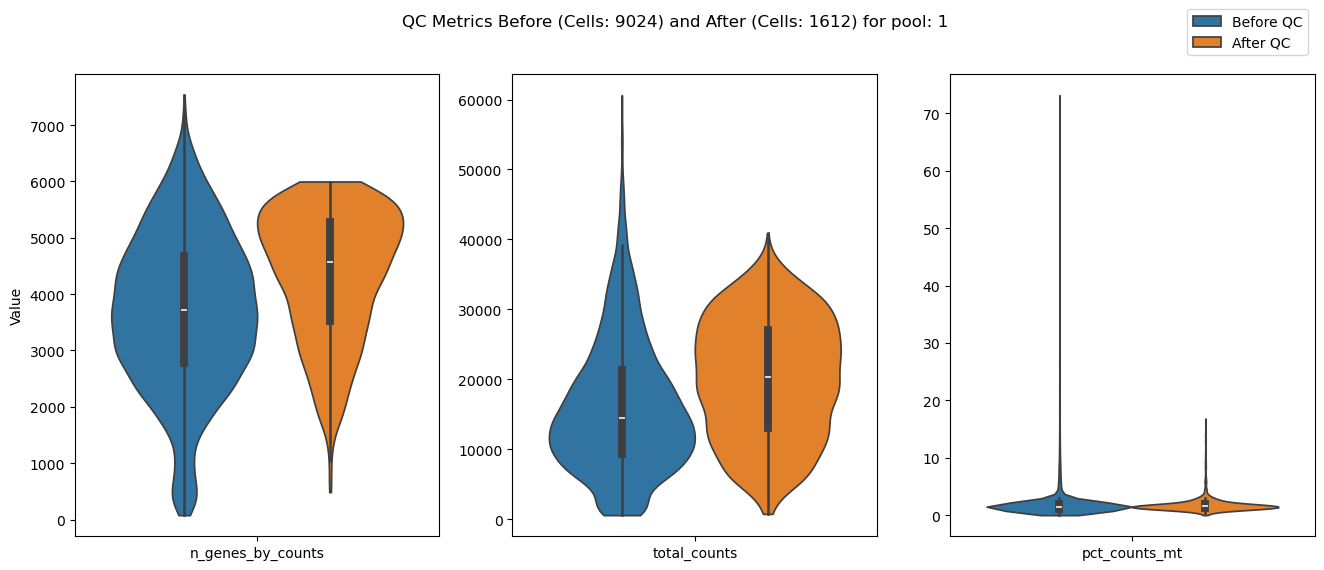

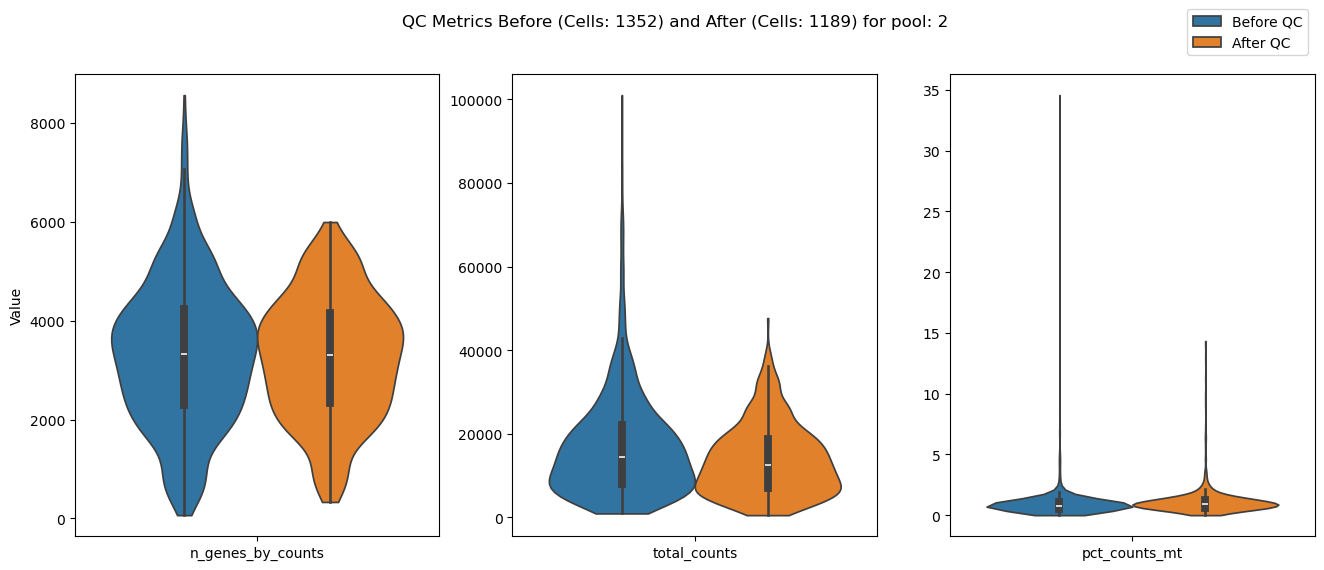

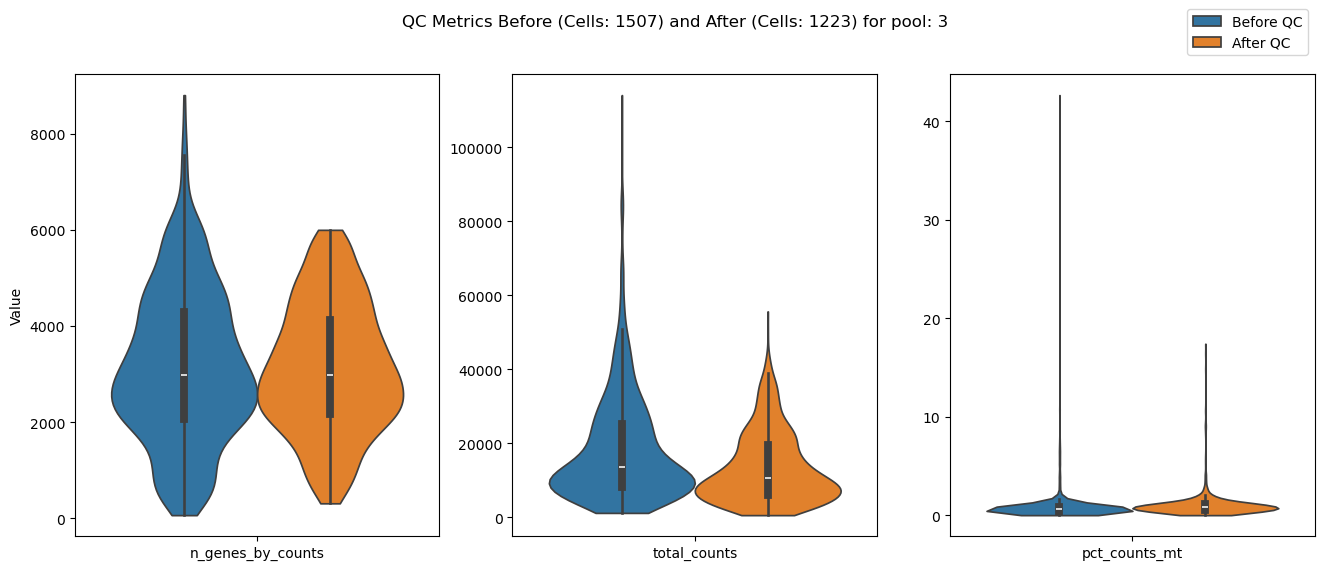

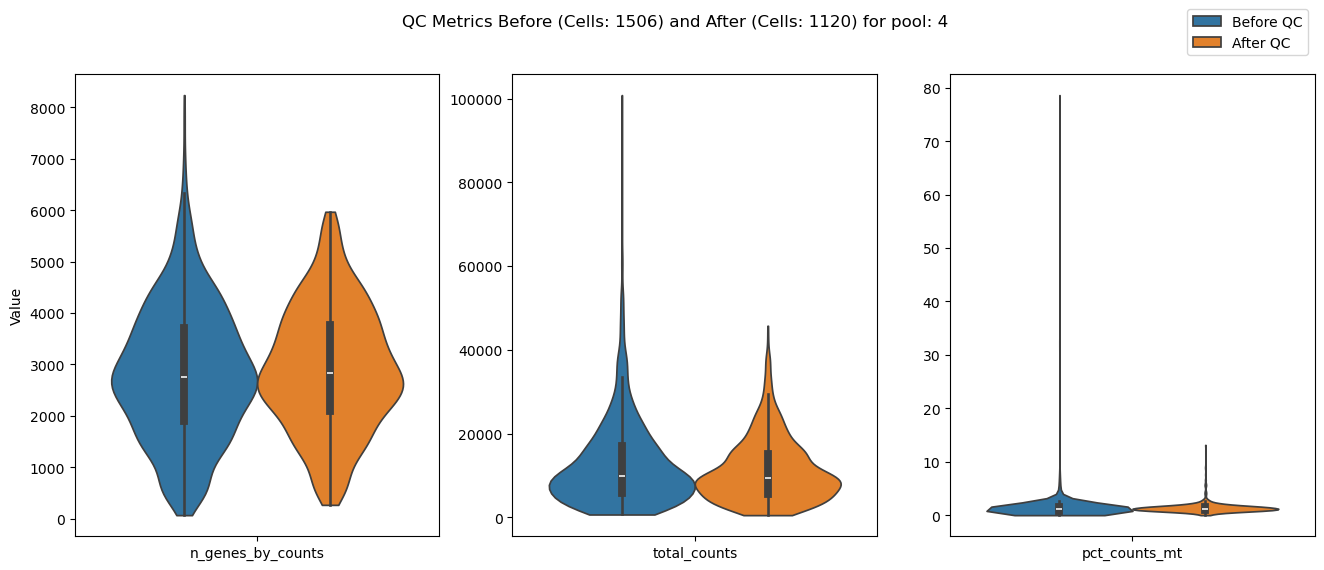

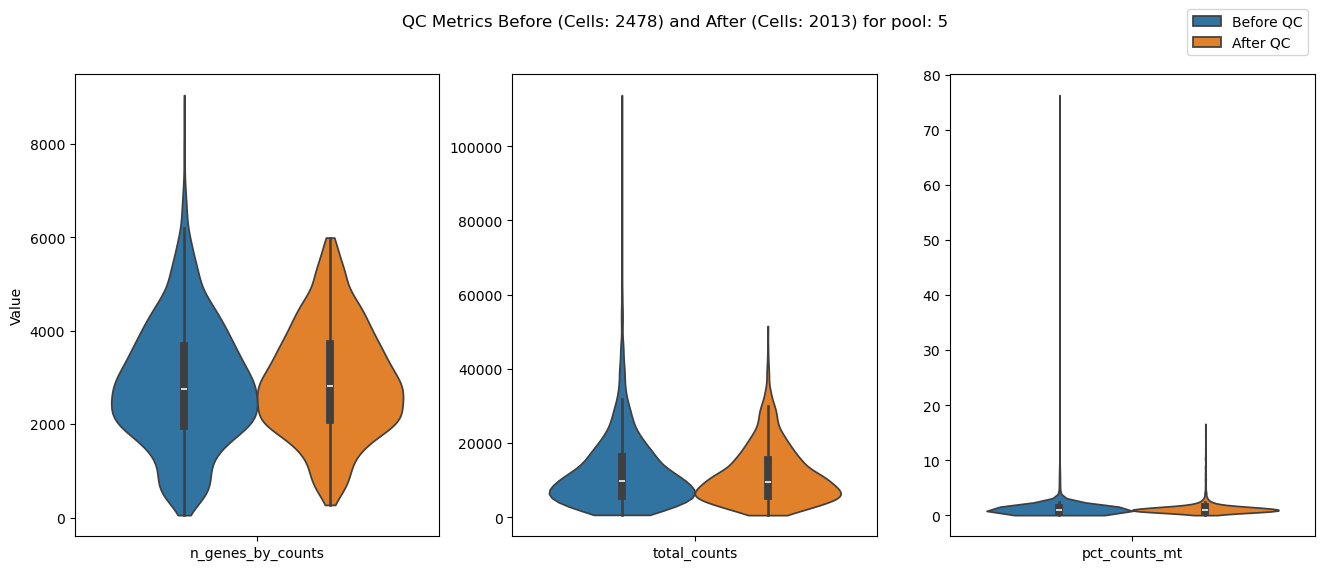

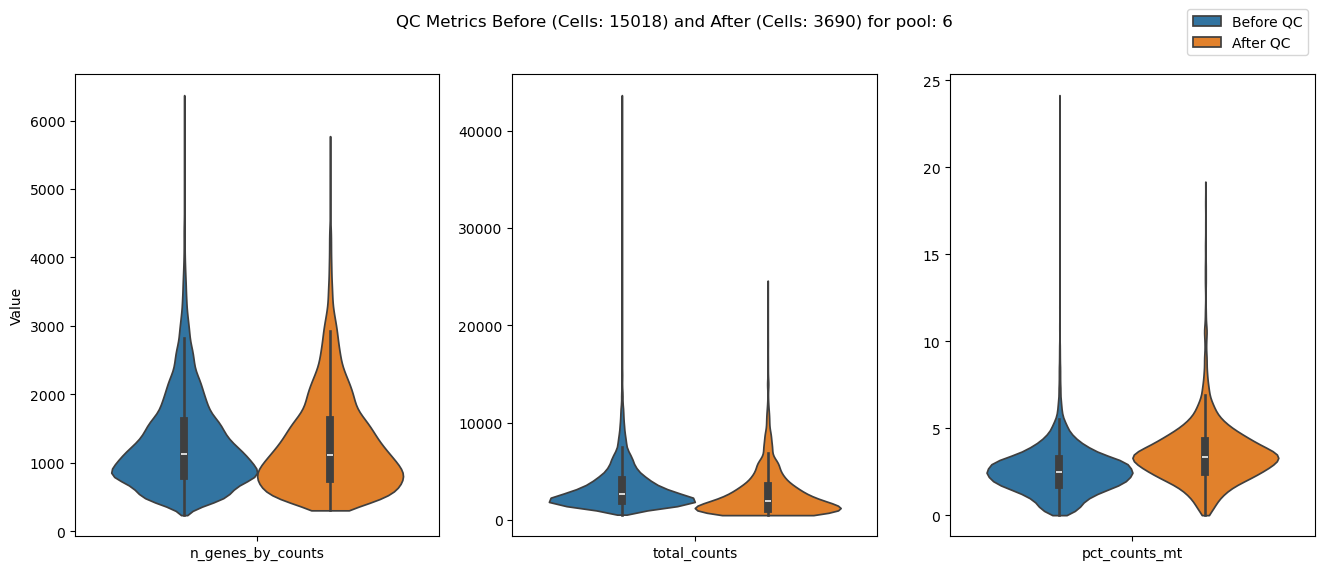

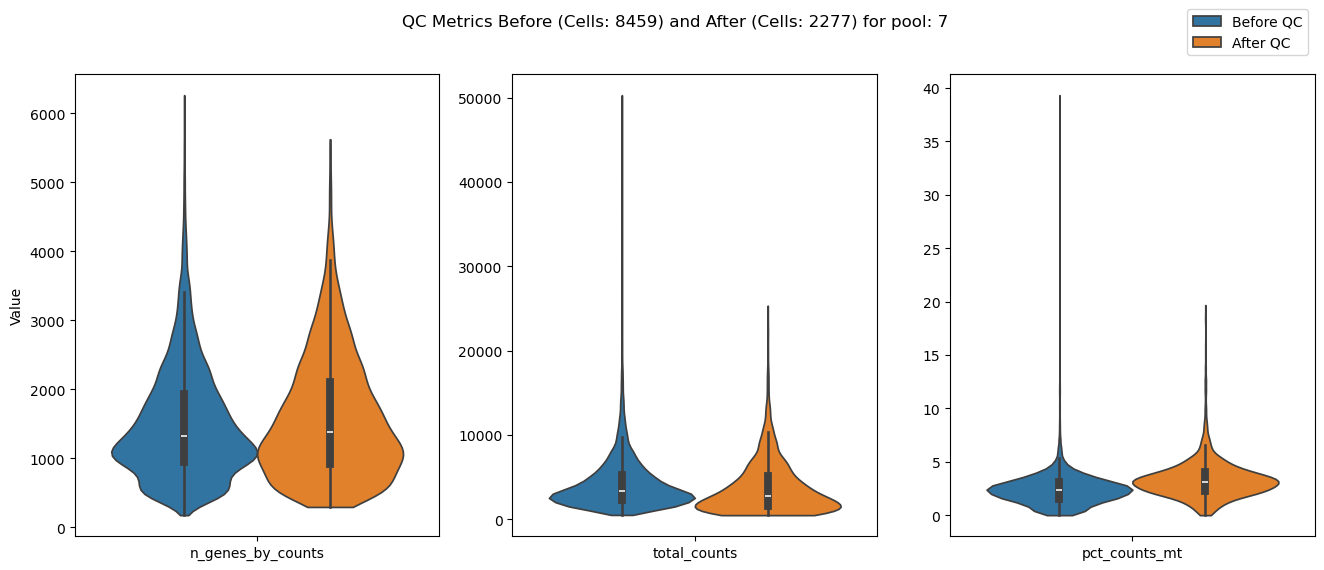

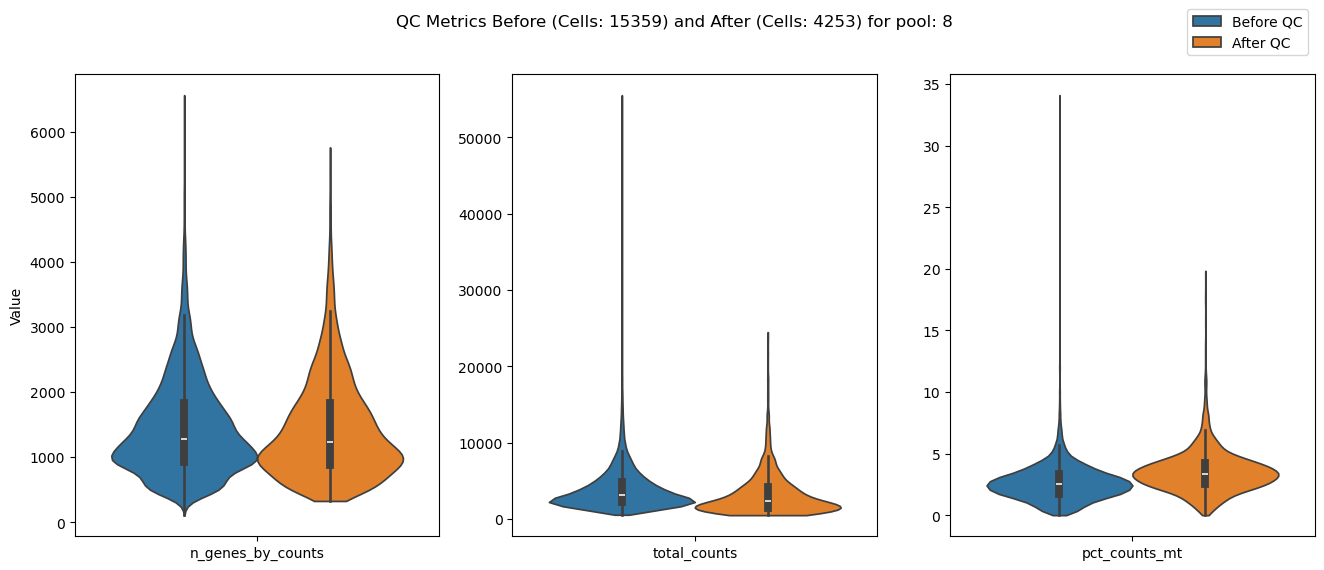

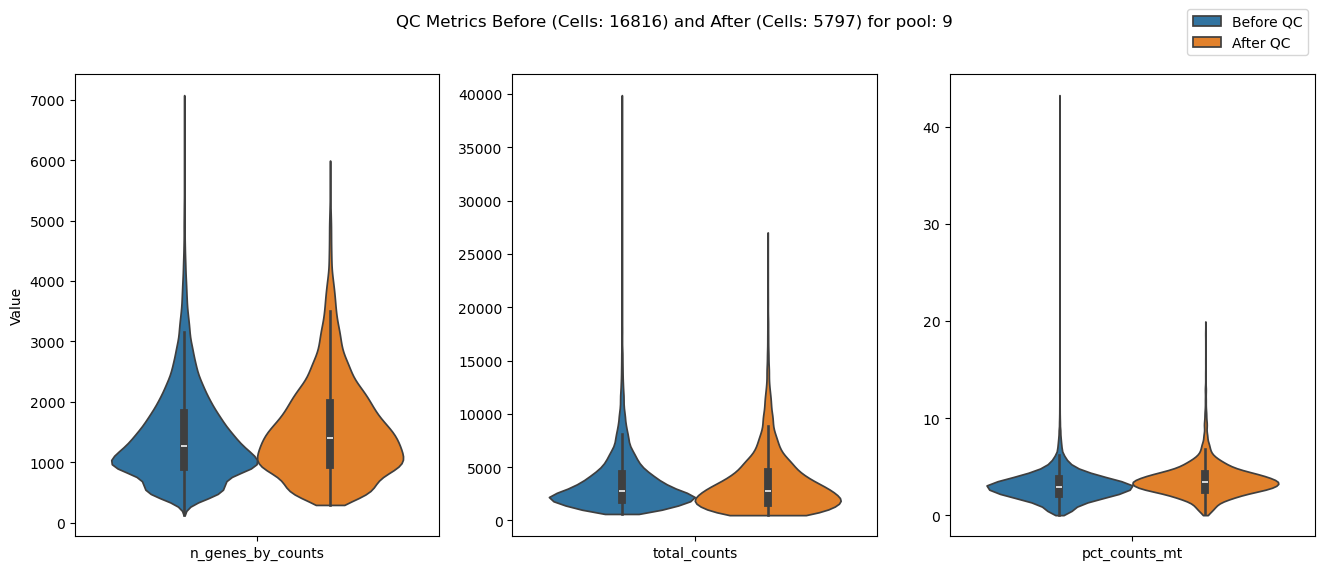

In [13]:
path = './03_results/figures/HTODemux_abs_calagry/'
dp.plot_qc_metrics(adatas, adatas_qc, save_dir=path)

In [9]:
adatas = adatas_qc

In [10]:
sum([adata.shape[0] for adata in adatas])

23174

### 4. Perform SoupX to correct for ambient mRNA

In [12]:
adatas[0].obs

,Classification,Classification_global,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,outlier
AAACCTGAGACAGGCT-1,d0-P,Singlet,5322,8.579792,30008.0,10.309253,297.0,5.697093,0.989736,False
AAACCTGCACAGGTTT-1,d0-DM,Singlet,3524,8.167636,13266.0,9.493035,42.0,3.761200,0.316599,False
AAACCTGCATGAAGTA-1,d0-C,Singlet,5576,8.626406,32831.0,10.399158,281.0,5.641907,0.855898,False
AAACCTGGTAGGACAC-1,d0-DM,Singlet,5796,8.665096,30228.0,10.316557,444.0,6.098074,1.468837,False
AAACCTGTCGCATGGC-1,d0-DM,Singlet,2760,7.923348,9501.0,9.159258,84.0,4.442651,0.884117,False
...,...,...,...,...,...,...,...,...,...,...
TTTGGTTCACTTCGAA-1,d0-P,Singlet,4980,8.513386,25564.0,10.148979,457.0,6.126869,1.787670,False
TTTGGTTTCTGCCCTA-1,d0-C,Singlet,4066,8.310661,16139.0,9.689056,233.0,5.455321,1.443708,False
TTTGTCAAGACAAGCC-1,d0-DM,Singlet,3461,8.149602,10947.0,9.300912,23.0,3.178054,0.210103,False
TTTGTCAGTCAATACC-1,d0-C,Singlet,3120,8.045909,9744.0,9.184509,300.0,5.707110,3.078818,False


In [44]:
# adatas_raw = [dp.hashing_columns(adata) for adata in adatas_raw]
groups = [dp.pregroup(adata) for adata in adatas]
adatas = [dp.cook_soup(adata, adata_raw, group) for (adata, adata_raw, group) in zip(adatas, adatas_raw, groups)]

In [ ]:
%R all_obj <- list()
for adata in adatas:  
    classification = adata.obs.Classification  
    mt_counts = adata.obs.pct_counts_mt
    %R -i adata -i classification -i mt_counts
    %R assay(adata, 'X') <- as(as.matrix(assay(adata, 'X')), 'dgCMatrix')
    %R adata_seurat <- CreateSeuratObject(counts = assay(adata, 'X'))
    # %R adata_seurat$Classification <- adata@colData["Classification"] 
    %R adata_seurat$Classification <- classification
    %R adata_seurat$percent.mt <- mt_counts
    %R all_obj[[length(all_obj)+1]] <- adata_seurat 
# %R print(all_obj[[1]]$Classification)

### 5. Concatenate/merge all the pools

In [280]:
r_code = '''AAA <- lapply(all_obj, function(x) {
  x <- NormalizeData(x)
  x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 6000)
  return(x)
})'''
ro.r(r_code)

o{'None': An object of class Seurat 
33696 features across 1612 samples within 1 assay 
Active assay: RNA (33696 features, 6000 variable features)
 2 layers present: counts, data
, 'None': An object of class Seurat 
33696 features across 1189 samples within 1 assay 
Active assay: RNA (33696 features, 6000 variable features)
 2 layers present: counts, data
, 'None': An object of class Seurat 
33696 features across 1223 samples within 1 assay 
Active assay: RNA (33696 features, 6000 variable features)
 2 layers present: counts, data
, 'None': An object of class Seurat 
33696 features across 1120 samples within 1 assay 
Active assay: RNA (33696 features, 6000 variable features)
 2 layers present: counts, data
, 'None': An object of class Seurat 
33696 features across 2013 samples within 1 assay 
Active assay: RNA (33696 features, 6000 variable features)
 2 layers present: counts, data
, 'None': An object of class Seurat 
33696 features across 3690 samples within 1 assay 
Active assay: RNA

In [ ]:
%R anchors <- FindIntegrationAnchors(object.list = AAA, dims=1:30)
%R integrated_data <- IntegrateData(anchorset = anchors, dims=1:30)
#merge meta.data
%R metadata_combined <- do.call(rbind, lapply(AAA, function(x) x@meta.data))
%R rownames(metadata_combined) <- metadata_combined$cell
%R integrated_data <- AddMetaData(integrated_data, metadata_combined)
#subset the data to exclude dLNs
%R filtered_data <- subset(integrated_data, cells = rownames(integrated_data@meta.data)[!grepl("dLN", integrated_data@meta.data$Classification)])

  |                                                  | 0 % ~calculating   |++++++                                            | 11% ~04s           |++++++++++++                                      | 22% ~03s           |+++++++++++++++++                                 | 33% ~02s           |+++++++++++++++++++++++                           | 44% ~02s           |++++++++++++++++++++++++++++                      | 56% ~01s           |++++++++++++++++++++++++++++++++++                | 67% ~01s           |+++++++++++++++++++++++++++++++++++++++           | 78% ~01s           |+++++++++++++++++++++++++++++++++++++++++++++     | 89% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=05s  
  |                                                  | 0 % ~calculating   |++                                                | 3 % ~10m 12s       |+++                                               | 6 % ~09m 48s       |+++++                                             | 8 % ~08

'value'

In [195]:
#merge andata objects, do not include genes that are not present in all samples (join = 'inner'), set to join = 'outer' if wanting to retain all genes if present in at least one dataset
adata_merged = ad.concat(adatas, join='inner', label='dataset',index_unique='_')

#there are about 200 dLN cells left after using hashsolo with absolute QC, however there are around 6000 left when using HTODemux
adata_merged = adata_merged[ adata_merged.obs['Classification'].str.contains('d0')| adata_merged.obs['Classification'].str.contains('TIL')].copy()

In [197]:
sum(adata_merged.obs['Classification'].str.contains('dLN'))

0

In [199]:
adata_merged

AnnData object with n_obs × n_vars = 16907 × 33696
    obs: 'Classification', 'Classification_global', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'dataset'

### 6. Normalize the data using shifter logarithm or scran normalization

In [200]:
scales_counts = sc.pp.normalize_total(adata_merged, target_sum=1e4, inplace=False)
adata_merged.layers['log1p'] = sc.pp.log1p(scales_counts["X"], copy=True)

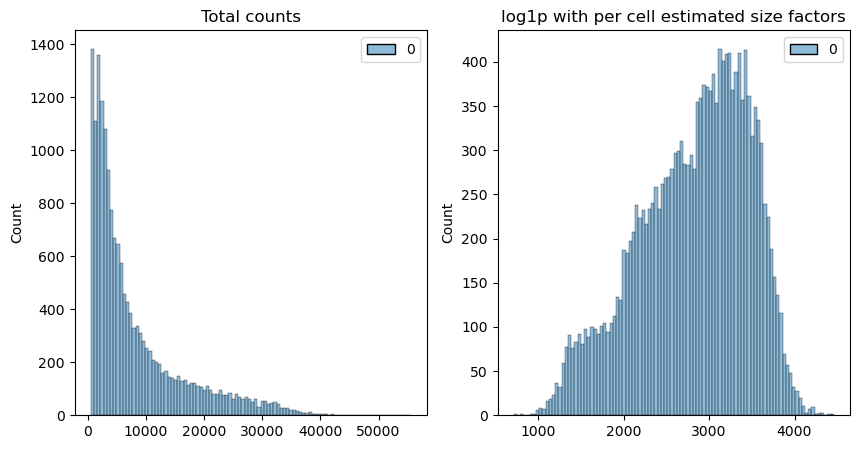

In [201]:
dp.plot_normalization(adata_merged, 'log1p', 'per cell')

In [202]:
#since scran does not really effectively normalize, we use the shifted logarithm
adata_merged.layers['counts'] = adata_merged.X
adata_merged.X = adata_merged.layers['log1p']

### 7. Perform feature selection

In [203]:
######
#alternatively with seurat, this yields about 60% the same genes, so its slightly different in selecting variale features, however the end result is extremely similar:
######
#first make the concatenated/merged data available to R 
adata_merged_seurat = adata_merged.copy()
adata_merged_seurat.obs['dataset'] = adata_merged_seurat.obs['dataset'].astype(str)
del adata_merged_seurat.uns
ro.globalenv["adata_merged_seurat"] = adata_merged_seurat

#convert from R singleCellObject into a seurat object and split the datasets into a list. Also rename the assay so it will be recognized by all R functions as the original assay
%R seurat <- as.Seurat(adata_merged_seurat, counts = "counts", data = "log1p") #counts = "soupX_counts" or "counts"
%R seurat <- RenameAssays(seurat, originalexp = "RNA")
%R batch_list <- SplitObject(seurat, split.by = "dataset")

#finally select highly variable genes in a batch aware way in seurat
%R seurat_features <- SelectIntegrationFeatures(batch_list, nfeatures=1000, fvf.nfeatures = 1000)
%R -o seurat_features

#subset the data based on the highly variable genes selected
adata_merged_hvg = adata_merged[:, seurat_features].copy()

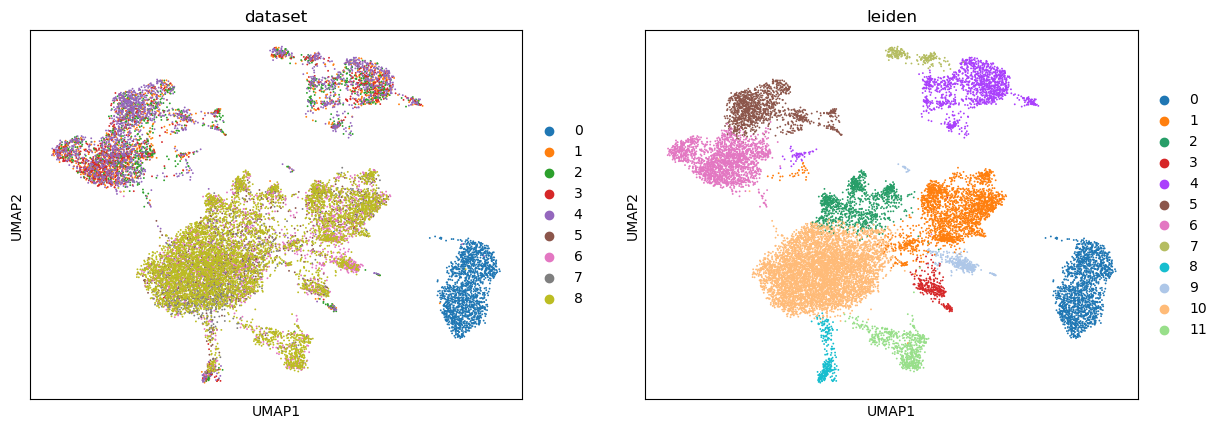

In [204]:
#plot the unintegrated data with coloring the discrete datasets to see their difference
sc.tl.pca(adata_merged_hvg, mask_var=None)
sc.pp.neighbors(adata_merged_hvg)
sc.tl.umap(adata_merged_hvg)
sc.tl.leiden(adata_merged_hvg, resolution=0.4, flavor="igraph" , n_iterations=2)
sc.pl.umap(adata_merged_hvg, color=['dataset', 'leiden'])

### 8. Perform data integration using Mutual Nearest Neighbots (since this is a way to effectively change the count matrix and unlike other integration methods, this yields not only a lower dimensional representation of the data)

In [210]:
#STACAS uses normalized counts, in seurats tutoral, they first do NormalizeData() and use seurat integration afterwards
%R integrated <-  Run.STACAS(batch_list, anchor.features = seurat_features, dims = 1:30) #rownames(seurat) for all features, anchor_features for scanpy version, seurat_features for seurat version

%R integrated_expr <- GetAssayData(integrated)
%R integrated_expr <- t(integrated_expr)
%R -o integrated_expr

adata_merged_hvg.layers['integrated'] = integrated_expr
adata_merged_hvg.X = adata_merged_hvg.layers['integrated']

  |                                                  | 0 % ~calculating   |++++++                                            | 11% ~02s           |++++++++++++                                      | 22% ~01s           |+++++++++++++++++                                 | 33% ~01s           |+++++++++++++++++++++++                           | 44% ~01s           |++++++++++++++++++++++++++++                      | 56% ~01s           |++++++++++++++++++++++++++++++++++                | 67% ~00s           |+++++++++++++++++++++++++++++++++++++++           | 78% ~00s           |+++++++++++++++++++++++++++++++++++++++++++++     | 89% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=03s  
  |                                                  | 0 % ~calculating   |++                                                | 3 % ~01m 22s       |+++                                               | 6 % ~01m 21s       |+++++                                             | 8 % ~01

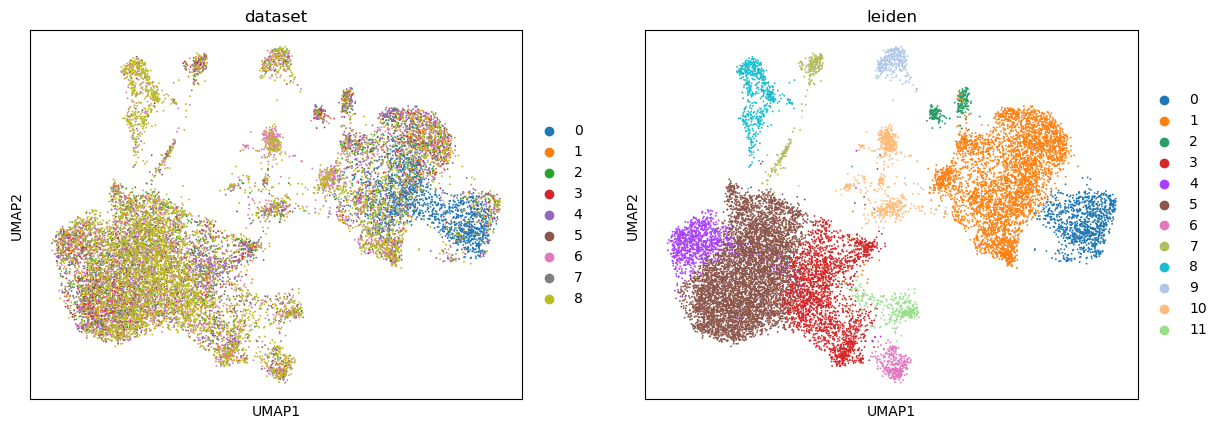

In [211]:
sc.tl.pca(adata_merged_hvg)
sc.pp.neighbors(adata_merged_hvg)
sc.tl.umap(adata_merged_hvg)
sc.tl.leiden(adata_merged_hvg, resolution=0.4, flavor="igraph" , n_iterations=2)
sc.pl.umap(adata_merged_hvg, color=['dataset', 'leiden'])

### 9. Perform Celltype annotation

In [212]:
#using scGate, this is based on the seurat object 'integrated' generated before by stacas. If you are using the integrated matrix from python, you will need to specify the new seurat object and remove reduction = "pca" so that scGate itself generates the pca reduction itself
%R sc_gating_models <- get_scGateDB()
%R seurat_object_annotated <- scGate(integrated, model = sc_gating_models$mouse$generic$Tcell, ncores = 4, reduction = "pca", output.col.name = "is.tcell") #, reduction = 'calculate', assay = 'originalexp'
%R annotation <- seurat_object_annotated@meta.data$is.tcell
%R -o annotation

adata_merged_hvg.obs['is_tcell'] = annotation
sum(adata_merged_hvg.obs.is_tcell == 'Pure')

  |======================================================================| 100%

  |======================================================================| 100%



4883

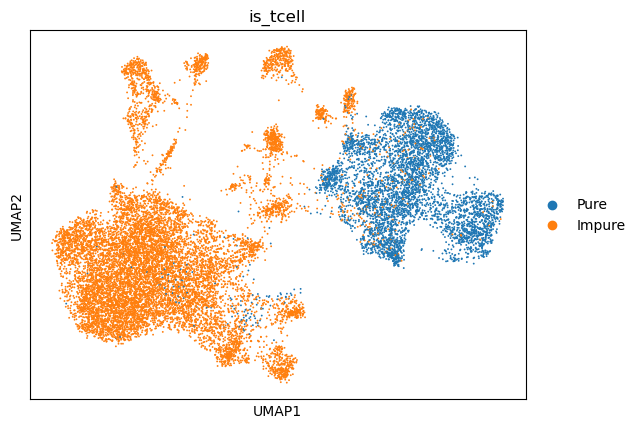

In [213]:
sc.pl.umap(adata_merged_hvg, color='is_tcell')

In [215]:
#download the reference datasets to map to
# %R download.file("https://figshare.com/ndownloader/files/41414556", destfile = "01_data/reference_datasets_project_TILs/CD8T_human_ref_v1.rds")
%R download.file("https://figshare.com/ndownloader/files/39012395", destfile = "01_data/reference_datasets_project_TILs/CD4T_human_ref_v2.rds")

'value'

In [216]:
%R ref.CD8 <- load.reference.map("01_data/reference_datasets_project_TILs/CD8T_human_ref_v1.rds")
%R ref.CD4 <- load.reference.map("01_data/reference_datasets_project_TILs/CD4T_human_ref_v2.rds") ##v2
%R DefaultAssay(ref.CD8) <- "integrated"
%R DefaultAssay(ref.CD4) <- "integrated"

[1] "Loading Custom Reference Atlas..."
[1] "Loaded Custom Reference map Human CD8 TILs"
[1] "Loading Custom Reference Atlas..."
[1] "Loaded Custom Reference map custom_reference"


'value'

In [217]:
adata_pure = adata_merged_hvg[adata_merged_hvg.obs['is_tcell'] == 'Pure']

%R ncores <- 8
%R pure_cells <- subset(seurat_object_annotated, subset = is.tcell == "Pure")
%R DefaultAssay(pure_cells) <- "RNA"
#CD4 first then CD8

# %R pure_cells_CD8 <- ProjecTILs.classifier(query = pure_cells, ref = ref.CD8, ncores = ncores) # , split.by = "dataset" filter.cells = FALSE, skip.normalize=TRUE,
%R pure_cells_CD4 <- ProjecTILs.classifier(query = pure_cells, ref = ref.CD4, ncores = ncores) # , split.by = "dataset" filter.cells = FALSE, skip.normalize=TRUE,
%R pure_cells_CD8_CD4 <- ProjecTILs.classifier(query = pure_cells_CD4, ref = ref.CD8, ncores = ncores, overwrite=FALSE) # , overwrite=FALSE
# %R pure_cells_CD8_CD4 <- ProjecTILs.classifier(query = pure_cells_CD8, ref = ref.CD4, ncores = ncores, overwrite=FALSE) # , overwrite=FALSE
%R TC_annotations <- pure_cells_CD8_CD4@meta.data$functional.cluster
%R -o TC_annotations 

adata_pure.obs['Tcell_subtype'] = TC_annotations
%R print(table(pure_cells_CD8_CD4$functional.cluster, useNA = "ifany"))

  |                                                                      |   0%[1] "Using assay RNA for query"
[1] "4310 out of 4883 ( 88% ) non-pure cells removed. Use filter.cells=FALSE to avoid pre-filtering"
[1] "Transforming expression matrix into space of orthologs"
[1] "Aligning query to reference map for batch-correction..."
  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~06s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=06s  
  |                                                  | 0 % ~calculating   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=04s  

Projecting corrected query onto Reference PCA space

Projecting corrected query onto Reference UMAP space
  |======================================================================| 100%

  |                                                                      |   0%[1] "Using assay RNA for query"
[1

/tmp/ipykernel_3758610/1525123344.py:15: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_pure.obs['Tcell_subtype'] = TC_annotations



  CD4.CTL_Exh  CD4.CTL_GNLY CD4.NaiveLike       CD4.Tfh      CD4.Th17 
           31             1            38           112           136 
     CD4.Treg        CD8.CM        CD8.EM CD8.NaiveLike       CD8.TEX 
          255            75           140            58           873 
     CD8.TPEX          <NA> 
         1734          1430 


'value'

In [218]:
pure_cells = sum(adata_merged_hvg.obs['is_tcell'] == 'Pure')
not_annotated_cells = sum(pd.isnull(adata_pure.obs.Tcell_subtype))
diff = pure_cells - not_annotated_cells
print(f'Pure Cells: {pure_cells}')
print(f'From which {not_annotated_cells} could not be annotated')
print(f'{diff} were annotated')

Pure Cells: 4883
From which 1430 could not be annotated
3453 were annotated


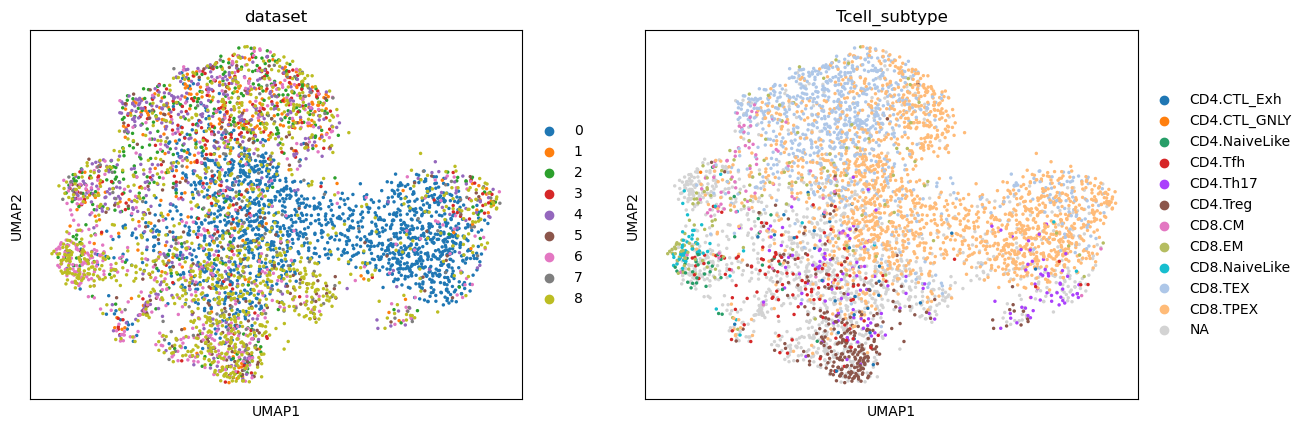

In [219]:
sc.tl.pca(adata_pure)
sc.pp.neighbors(adata_pure)
sc.tl.umap(adata_pure)
sc.tl.leiden(adata_pure, resolution=0.4, flavor="igraph" , n_iterations=2)
sc.pl.umap(adata_pure, color=['dataset', 'Tcell_subtype'])

### 11. Save the progress

In [38]:
adata_pure.write('01_data/processed/merged_and_processed/HTODemux_abs_1000_nosoup.h5ad', compression='gzip') #takes forever 